In [8]:
%load_ext autoreload
%autoreload 2

# Add other paths
import os, sys
sys.path.append(os.path.abspath(os.path.join("../")))
import os
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics
import glob
import datetime as dt
from sklearn.metrics import r2_score
from tqdm.auto import tqdm

import helper_libraries.results_tools as results_tools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Import Data

In [9]:
# Load returns and spreads
fret_df, hrf_df = results_tools.load_mkt_rf_returns()
spread_df = results_tools.load_spreads()

# Main

## Params

In [10]:
## Params
# List of all results folders
results_folders = (
    pd.read_excel("../../results/key.xlsx").query('"Done" in Notes')["Folder"].to_list()
)  ##### <------------------ Finish models!
# Year to start trading
start_year = "2004"

# Define strategies and models
strategies_list = [
    "Market",
    "Sign",
    "Positive",
    "Tanh",
    "MS Strategy 2",
    "MS Strategy 1",
]
model_list = ["Benchmark", "LR", "LR_PCA_select", "LR_Lasso_select", "Lasso", "Enet"]

# Latex table params
table_loc = "!h"  # Should be something like htbp
table_fontsize = "footnotesize"
table_output_folder = "../../docs/exhibits/tables"

# Metrics and their names
metrics_list = ["Return", "ReturnAdj", "Sharpe", "SharpeAdj", "Trades", "rvol"]
metrics_names_list = [
    "Return",
    "Adjusted Return",
    "Sharpe",
    "Adjusted Sharpe",
    "Trades",
    "Realized Volatility",
]

## Functions

In [11]:
def plot_returns(oss_returns_all_df):
    
    fig, axs = plt.subplots(figsize=(11, 7), nrows=int(len(model_list) / 2), ncols=2, sharey=True)

    for i, model_select in enumerate(model_list):

        ax = axs.reshape(-1)[i]
        oss_returns_strategy_df = oss_returns_all_df[model_select]
        
        # Plot cumulative returns
        sns.lineplot(
            x="datetime",
            y="value",
            hue="variable",
            data=oss_returns_strategy_df[["Market", "Sign", "Positive", "MS Strategy 1"]]
            .groupby(pd.Grouper(freq="1d"))
            .sum()
            .cumsum()
            .melt(ignore_index=False)
            .reset_index(),
            palette="Set2",
            lw=2,
            ax=ax,
        )
        
        # Highlight recessions
        ax.axvspan(pd.to_datetime('2007-12-01'), pd.to_datetime('2009-06-01'), color = 'k', alpha = 0.05) 
        ax.axvspan(pd.to_datetime('2020-02-01'), pd.to_datetime('2020-04-01'), color = 'k', alpha = 0.05) 
        
        # Other settings
        ax.set_title(model_select)
        ax.set_xlabel(None)
        ax.set_ylabel('Cumulative Return')
        ax.legend(loc="upper left")

    # Fix legend
    handles, labels = axs.reshape(-1)[0].get_legend_handles_labels()
    fig.legend(handles, labels, fontsize = 12, loc='lower center', ncol = 9, bbox_to_anchor=(0.5, 0))
    for ax in axs.reshape(-1):
        ax.get_legend().remove()
    
    # Make room for legend
    plt.tight_layout()
    plt.subplots_adjust(bottom = 0.125)
    
    return fig, axs

## Process each set of results

In [12]:
for folder_name in tqdm(results_folders):

    ### Prep
    ## Get forecast data
    forecast_oss_df, forecast_ins_df, results_folder_name = results_tools.load_model_results(
        folder_name=folder_name,
        debug=True,
    )

    # Model list?
    model_list = [
        x.replace("oss_", "") for x in forecast_oss_df.columns if "NN" not in x
    ]  ###################### <----- Remove this !!

    ## Get trading results
    # Filter data
    forecast_oss_filter_df = forecast_oss_df.loc[start_year:].copy()
    forecast_ins_filter_df = forecast_ins_df.loc[:start_year].copy()
    fret_filter_df = fret_df.loc[start_year:].copy()
    hrf_filter_df = hrf_df.loc[start_year:].copy()

    # Trading strategies
    (
        oss_results_all_df,
        oss_returns_all_df,
        oss_weights_all_df,
        oss_retpred_all_df,
    ) = results_tools.get_trading_results(
        forecast_oss_filter_df,
        forecast_ins_filter_df,
        spread_df,
        fret_filter_df["ff__mkt"],
        hrf_filter_df["rf"],
        strategies_list,
        model_list,
        hold_cash=True,
    )
    
    fig, _ = plot_returns(oss_returns_all_df)
    fig.savefig(
        f"../../docs/exhibits/figures/return_timing_{results_folder_name}.pdf"
    )
    plt.close()

  0%|          | 0/9 [00:00<?, ?it/s]

In [17]:
### Prep
## Get forecast data
forecast_oss_df, forecast_ins_df, results_folder_name = results_tools.load_model_results(
    folder_name='main',
    debug=True,
)

# Model list?
model_list = [
    x.replace("oss_", "") for x in forecast_oss_df.columns if "NN" not in x
]  ###################### <----- Remove this !!

## Get trading results
# Filter data
forecast_oss_filter_df = forecast_oss_df.loc[start_year:].copy()
forecast_ins_filter_df = forecast_ins_df.loc[:start_year].copy()
fret_filter_df = fret_df.loc[start_year:].copy()
hrf_filter_df = hrf_df.loc[start_year:].copy()

# Trading strategies
(
    oss_results_all_df,
    oss_returns_all_df,
    oss_weights_all_df,
    oss_retpred_all_df,
) = results_tools.get_trading_results(
    forecast_oss_filter_df,
    forecast_ins_filter_df,
    spread_df,
    fret_filter_df["ff__mkt"],
    hrf_filter_df["rf"],
    strategies_list,
    model_list,
    hold_cash=True,
)

## Latex

In [6]:
print(r"\section{Return Timing}")

for folder_name in tqdm(results_folders):

    results_folder_name = folder_name
    filename = f"../../docs/exhibits/figures/return_timing_{results_folder_name}.pdf"
    fig_label = 'return_timing_' + results_folder_name
                

    latex_str = (
r"""
\begin{figure}[""" + table_loc + r"""]
\caption{Cumulative Return -- """ + folder_name.replace("_", " ").title() + r"""}  
\label{fig:""" + fig_label + r"""}
\footnotesize
\vspace{-1em}
\begin{tabular}{@{\extracolsep{0em}}cc}
\includegraphics[width=0.99\linewidth]{"""
+ filename
+ r"""} \\
\multicolumn{2}{@{\hspace{0.2in}}p{0.95\linewidth}@{}}{ \textit{Note:} We compute and plot cumulative daily returns for each model and strategy pair. }     \\  
\end{tabular}
\end{figure}
"""
    )
    print(latex_str)

    print("\n\\clearpage\n")

\section{Return Timing}


  0%|          | 0/9 [00:00<?, ?it/s]


\begin{figure}[!h]
\caption{Cumulative Return -- Main}  
\label{fig:return_timing_main}
\footnotesize
\vspace{-1em}
\begin{tabular}{@{\extracolsep{0em}}cc}
\includegraphics[width=0.99\linewidth]{../../docs/exhibits/figures/return_timing_main.pdf} \\
\multicolumn{2}{@{\hspace{0.2in}}p{0.95\linewidth}@{}}{ \textit{Note:} We compute and plot cumulative daily returns for each model and strategy pair. }     \\  
\end{tabular}
\end{figure}


\clearpage


\begin{figure}[!h]
\caption{Cumulative Return -- Main Combined}  
\label{fig:return_timing_main_combined}
\footnotesize
\vspace{-1em}
\begin{tabular}{@{\extracolsep{0em}}cc}
\includegraphics[width=0.99\linewidth]{../../docs/exhibits/figures/return_timing_main_combined.pdf} \\
\multicolumn{2}{@{\hspace{0.2in}}p{0.95\linewidth}@{}}{ \textit{Note:} We compute and plot cumulative daily returns for each model and strategy pair. }     \\  
\end{tabular}
\end{figure}


\clearpage


\begin{figure}[!h]
\caption{Cumulative Return -- Main Cts}  
\labe

# Scratch

## Difference between model returns and market

In [22]:
folder_name = 'main'

### Prep
## Get forecast data
forecast_oss_df, forecast_ins_df, results_folder_name = results_tools.load_model_results(
    folder_name=folder_name,
    debug=True,
)

# Model list?
model_list = [
    x.replace("oss_", "") for x in forecast_oss_df.columns if "NN" not in x
]  ###################### <----- Remove this !!

## Get trading results
# Filter data
forecast_oss_filter_df = forecast_oss_df.loc[start_year:].copy()
forecast_ins_filter_df = forecast_ins_df.loc[:str(int(start_year)-1)].copy()
fret_filter_df = fret_df.loc[start_year:].copy()
hrf_filter_df = hrf_df.loc[start_year:].copy()

# Trading strategies
(
    oss_results_all_df,
    oss_returns_all_df,
    oss_weights_all_df,
    oss_retpred_all_df,
) = results_tools.get_trading_results(
    forecast_oss_filter_df,
    forecast_ins_filter_df,
    spread_df,
    fret_filter_df["ff__mkt"],
    hrf_filter_df["rf"],
    strategies_list,
    model_list,
    hold_cash=False,
)

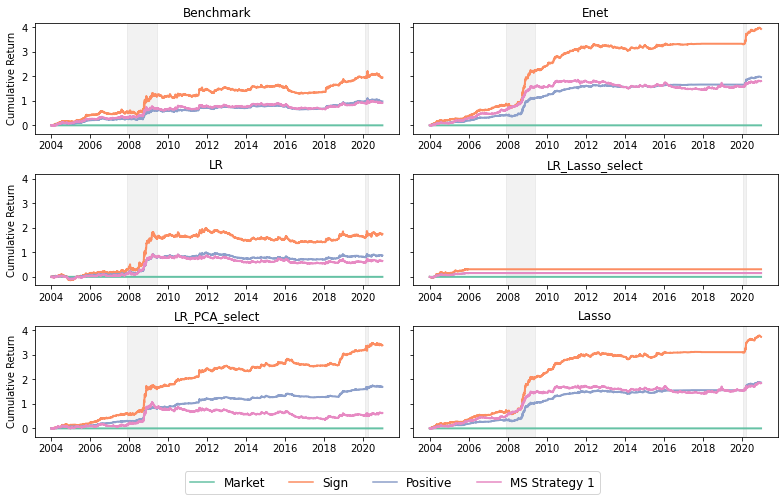

In [23]:
fig, _ = plot_returns(oss_returns_all_df.subtract(oss_returns_all_df['Benchmark']['Market'].values, axis=0))
fig.savefig(
    f"../../docs/exhibits/figures/return_timing_main_diff.pdf"
)